## Import Packages

In [1]:
import itertools
import os

import fiona
import geopandas as gpd
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
from pathlib import Path
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
from tqdm import tqdm

## Define Variables

In [2]:
folderpath = '../data'
filename = 'cdl_apples_southern'
random_state = 42

## Define Functions

In [3]:
def load_cdl(filepath):
    """
    Load a GeoTIFF file, create points from valid pixel values, and convert to a GeoDataFrame in EPSG:4326.
    
    Parameters:
        filepath (str): The file path to the GeoTIFF file.
        
    Returns:
        GeoDataFrame: A GeoDataFrame containing point geometries for valid pixel values, 
                      with coordinates in EPSG:4326.
    """
    with rio.open(filepath) as src:
        # Read the first band with masking
        image = src.read(1, masked=True)

        # Get row, column indices for valid pixel values
        rows, cols = np.where(image < 255)

        # Create point geometries using affine transformation
        transform = src.transform
        geoms = [Point(transform * (col, row)) for row, col in zip(rows, cols)]

        # Create GeoDataFrame with the specified CRS
        gdf = gpd.GeoDataFrame(geometry=geoms, crs=src.crs)

    # Return GeoDataFrame in EPSG:4326
    return gdf.to_crs('EPSG:4326')

In [4]:
def load_gdf(folderpath, filename):
    """
    Load a GeoDataFrame from specified interim or raw directories based on availability.
    
    Parameters:
    - folderpath: A string specifying the path to the main folder containing 'raw' and 'interim' subfolders.
    - filename: The name of the file (without extension for interim, with '.TIF' extension for raw) to load.
    
    Returns:
    - A GeoDataFrame loaded from the specified file. If the file is present in the 'interim' directory,
      it is loaded from there; otherwise, it is loaded from the 'raw' directory as a GeoTIFF file.
    
    """
    # Create Path object for folderpath to ensure correct path manipulation
    folder = Path(folderpath)

    # Construct file paths for raw and interim versions of the file
    filepath_raw = folder / 'raw' / f'{filename}.TIF'
    filepath_interim = folder / 'interim' / filename

    # Attempt to read the GeoDataFrame from the interim directory
    if filepath_interim.is_dir():
        gdf = gpd.read_file(str(filepath_interim)).drop(columns=['FID'])
    # Fallback to loading the GeoTIFF from the raw directory
    else:
        gdf = load_cdl(filepath_raw)
    
    return gdf

In [5]:
def save_gdf(folderpath, filename, geodataframe):
    """
    Saves a GeoDataFrame to a file in a specified directory.

    Parameters:
    - folderpath: The directory where the file will be saved.
    - filename: The name of the file to save the GeoDataFrame as.
    - geodataframe: The GeoDataFrame to be saved.
    """
    # Create Path object for folderpath to ensure correct path manipulation
    folder = Path(folderpath)

    # Combine the filepath and filename to create the full path to the file
    filepath = folder / 'interim' / filename

    # Save the GeoDataFrame to the specified file in write mode
    geodataframe.to_file(str(filepath), mode='w')

In [6]:
def combine_gdfs(folderpath, filenames):
    """
    Combines multiple GeoDataFrames from specified filenames within a given folder path,
    utilizing the `load_gdf` function to load each GeoDataFrame.

    Parameters:
    - folderpath (str): The path to the folder containing the files.
    - filenames (list): A list of strings representing the names of the files to be combined.

    Returns:
    - pd.DataFrame: A single pandas DataFrame containing all the data from the GeoDataFrames specified in the filenames list.
    """
    # Initialize an empty list to store GeoDataFrames
    gdfs = []

    # Use the load_gdf function to load each GeoDataFrame and append it to the list
    for filename in filenames:
        gdfs.append(load_gdf(folderpath, filename))
        
    # Concatenate all loaded GeoDataFrames into a single DataFrame and return it
    return pd.concat(gdfs, ignore_index=True)

In [7]:
def collect_gdf_statistics(geodataframe):
    # Copy the GeoDataFrame to avoid modifying the original data
    gdf = geodataframe.copy()
    
    # Extract coordinates
    x = gdf.geometry.x
    y = gdf.geometry.y

    stats = {
        'x': {'mean': x.mean(), 'std': x.std()}, 
        'y': {'mean': y.mean(), 'std': y.std()},
    }

    return stats

In [8]:
def find_hdbscan_clusters(geodataframe, **params):
    """
    Finds clusters in a GeoDataFrame using the HDBSCAN clustering algorithm.

    Parameters:
    - geodataframe: GeoDataFrame, the GeoDataFrame containing the geometries to cluster.
    - **params: Any, additional keyword arguments passed directly to the HDBSCAN constructor.

    Returns:
    - GeoDataFrame: A new GeoDataFrame with the original data and an additional 'cluster' column representing the cluster labels.
    """
    # Copy the GeoDataFrame to avoid modifying the original data
    gdf = geodataframe.copy()
    
    # Extract coordinates as a numpy array
    coords = np.array(list(zip(gdf.geometry.y, gdf.geometry.x)))
    
    # Initialize HDBSCAN with provided parameters and fit to coordinates
    dbscan = hdbscan.HDBSCAN(**params)
    cluster_labels = dbscan.fit_predict(np.radians(coords))
    
    # Assign cluster labels to a new column in the GeoDataFrame
    gdf['cluster'] = cluster_labels

    return gdf

In [9]:
def plot_clusters(geodataframe):
    """
    Plots the clusters found in a GeoDataFrame.
    
    Parameters:
    - geodataframe: The GeoDataFrame containing the geometries to cluster.
    
    Returns:
    - fig, ax: The figure and axes objects of the plot.
    """
    # Copy the GeoDataFrame to avoid modifying the original data
    gdf = geodataframe.copy()
    
    # Create a plot and axes object
    fig, ax = plt.subplots()
    ax.set_xlabel = 'Latitude'
    ax.set_ylabel = 'Longitude'
    
    # Plot all geometries in light gray to provide a background
    gdf.plot(ax=ax, color='lightgray', markersize=5)
    
    # Overlay the clusters, excluding the noise (cluster label -1)
    gdf[gdf['cluster'] != -1].plot(ax=ax, column='cluster', markersize=5, categorical=True)
    
    # Return the figure and axes for further manipulation
    return fig, ax

In [10]:
def generate_cluster_figures(function, geodataframe, **params):
    """
    Generates figures for each set of cluster parameters.

    Parameters:
    - function: A function that performs clustering.
    - geodataframe: The GeoDataFrame to be clustered.
    - **params: Clustering parameters.

    Yields:
    - A matplotlib figure object for each set of clustering parameters.
    """
    gdf = geodataframe.copy()
    combinations = list(itertools.product(*params.values()))

    for combination in combinations:
        kwargs = dict(zip(params.keys(), combination))
        gdf_clusters = function(gdf, **kwargs)
    
        # Return select parameters
        kwargs.pop('metric')
        kwargs.pop('core_dist_n_jobs')
        
        # Plot the clusters
        fig, ax = plot_clusters(gdf_clusters)
        
        yield fig

In [11]:
def generate_cluster_statistics(function, geodataframe, random_state=42, **params):
    """
    Generates statistics for each set of cluster parameters.

    Parameters:
    - function: A function that performs clustering.
    - geodataframe: The GeoDataFrame to be clustered.
    - **params: Clustering parameters.

    Yields:
    - A dictionary with statistics for each set of parameters.
    """
    gdf = geodataframe.copy()

    # Generate and iterate over all combinations of the provided parameters
    combinations = list(itertools.product(*params.values()))

    for combination in combinations:
        kwargs = dict(zip(params.keys(), combination))
        df_clusters = function(gdf, **kwargs)

        # Return select parameters
        kwargs.pop('metric')
        kwargs.pop('core_dist_n_jobs')

        # Use GeoPandas .xy attributes to extract coordinates into a numpy array
        x, y = df_clusters.geometry.x, df_clusters.geometry.y
        X = np.column_stack([x, y])

        labels = df_clusters['cluster']
        
        # Only calculate the silhouette score if there are at least 2 clusters (excluding noise if -1 is used for noise)
        unique_labels = set(labels)
        unique_labels.discard(-1)  # Discard noise label if used
        if len(unique_labels) > 1:
            silhouette = silhouette_score(X, labels, random_state=random_state)
        else:
            silhouette = None

        stats = {
            'parameters': kwargs,
            'number_of_clusters': len(unique_labels),
            'number_of_outliers': sum(labels == -1),
            'silhouette_score': silhouette,
        }

        yield stats

In [12]:
def collect_cluster_statistics(function, geodataframe, **params):
    """
    Collects statistics from clustering models evaluated with various parameters,
    organizes them into a Pandas DataFrame, and flattens parameter dictionaries
    for easier analysis.

    Parameters:
    - function: The clustering function to evaluate.
    - geodataframe: A GeoDataFrame on which to perform clustering.
    - **params: Parameter combinations to pass to the clustering function.

    Returns:
    - A Pandas DataFrame containing statistics for each set of parameters
      evaluated by the clustering function, with each parameter as a separate column.
    """
    # Copy the GeoDataFrame to avoid modifications to the original data
    gdf = geodataframe.copy()

    # Initialize an empty list to collect stats dictionaries
    list_stats = []

    # Loop through the generator function to collect figures and stats
    for stats in generate_cluster_statistics(function, gdf, **params):
        list_stats.append(stats)

    # Convert the list of stats dictionaries into a Pandas DataFrame
    df_stats = pd.DataFrame(list_stats)

    # Flatten parameters and merge with the rest of the DataFrame
    if 'parameters' in df_stats.columns:
        df_parameters = pd.json_normalize(df_stats['parameters'])
        df_stats = pd.concat([df_stats.drop(columns=['parameters']), df_parameters], axis=1)

    return df_stats

## Execute Functions

### Load GeoDataFrames

In [13]:
# Load a GeoTIFF file from CroplandCROS as a GeoDataFrame
gdf = load_gdf(folderpath, filename)

# Save the GeoDataFrame
# save_gdf('../data/interim', filename.split('.')[0], gdf)

In [14]:
# Combine East Coast GeoTIFF files from CroplandCROS
# gdf = combine_gdfs('../data', ['cdl_apples_northeastern', 'cdl_apples_easternmountain', 'cdl_apples_southern'])

# Save the East Coast GeoDataFrame
# save_gdf('../data/interim', 'cdl_apples_eastcoast', gdf)

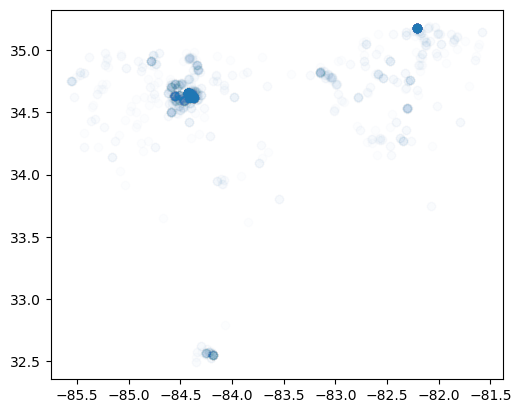

In [15]:
# Plot the GeoDataFrame to visualize potential polygons
gdf.plot(alpha=0.01)
plt.show()

### Create Clusters

#### Southern Region

In [16]:
# Load GeoDataFrame
gdf = load_gdf(folderpath, 'cdl_apples_southern')

In [17]:
# Set parameter ranges and collect statistics
params = {
    'min_cluster_size': np.arange(100, 600, 100),
    'min_samples': np.arange(5, 25, 5),
    'cluster_selection_epsilon': [0.01, 0.1, 1.0, 10.0], 
    'metric': ['haversine'],
    'core_dist_n_jobs': [-1],
}

df = collect_cluster_statistics(find_hdbscan_clusters, gdf, **params)

In [18]:
# Compare silhouette scores
df.sort_values(['silhouette_score', 'min_cluster_size', 'min_samples', 'cluster_selection_epsilon'], ascending=False)

,number_of_clusters,number_of_outliers,silhouette_score,min_cluster_size,min_samples,cluster_selection_epsilon
67,2,122,0.827923,500,5,10.00
66,2,122,0.827923,500,5,1.00
65,2,122,0.827923,500,5,0.10
64,2,122,0.827923,500,5,0.01
51,2,122,0.827923,400,5,10.00
...,...,...,...,...,...,...
28,2,126,0.824784,200,20,0.01
15,2,126,0.824784,100,20,10.00
14,2,126,0.824784,100,20,1.00
13,2,126,0.824784,100,20,0.10


Figure(640x480)


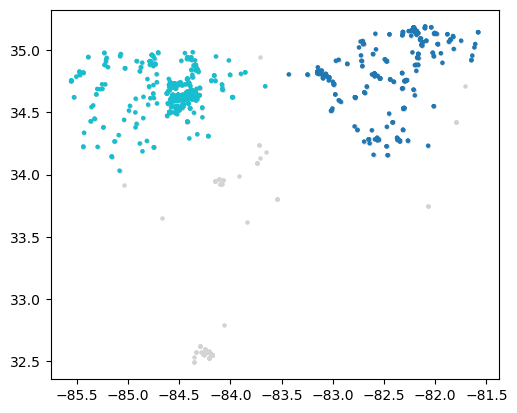

In [19]:
# Plot clusters for parameters yielding the highest silhouette score
params = {
    'min_cluster_size': [500],
    'min_samples': [10],
    'cluster_selection_epsilon': [10], 
    'metric': ['haversine'],
    'core_dist_n_jobs': [-1],
}

for fig in generate_cluster_figures(find_hdbscan_clusters, gdf, **params):
    print(fig)

#### Eastern Mountain Region

In [20]:
# Load GeoDataFrame
gdf = load_gdf(folderpath, 'cdl_apples_easternmountain')

In [21]:
# Sample GeoDataFrame
gdf_sample = gdf.sample(n=10000, random_state=random_state)

In [22]:
# Compare sample distribution to GeoDataFrame distribution
print(collect_gdf_statistics(gdf))
print(collect_gdf_statistics(gdf_sample))

{'x': {'mean': -80.32751445611852, 'std': 1.9667861783690612}, 'y': {'mean': 37.17606365450837, 'std': 1.7858363445816337}}
{'x': {'mean': -80.323445313467, 'std': 1.9711881977029864}, 'y': {'mean': 37.17853710194878, 'std': 1.7853417007385393}}


In [23]:
# Set parameter ranges and collect statistics
params = {
    'min_cluster_size': np.arange(100, 600, 100),
    'min_samples': np.arange(5, 25, 5),
    'cluster_selection_epsilon': [0.01, 0.1, 1.0, 10.0], 
    'metric': ['haversine'],
    'core_dist_n_jobs': [-1],
}

df = collect_cluster_statistics(find_hdbscan_clusters, gdf_sample, **params)

In [24]:
# Compare silhouette scores
df.sort_values(['silhouette_score', 'min_cluster_size', 'min_samples', 'cluster_selection_epsilon'], ascending=False)

,number_of_clusters,number_of_outliers,silhouette_score,min_cluster_size,min_samples,cluster_selection_epsilon
71,2,12,0.742422,500,10,10.00
70,2,12,0.742422,500,10,1.00
69,2,12,0.742422,500,10,0.10
68,2,12,0.742422,500,10,0.01
55,2,12,0.742422,400,10,10.00
...,...,...,...,...,...,...
16,2,143,0.674496,200,5,0.01
3,2,143,0.674496,100,5,10.00
2,2,143,0.674496,100,5,1.00
1,2,143,0.674496,100,5,0.10


Figure(640x480)


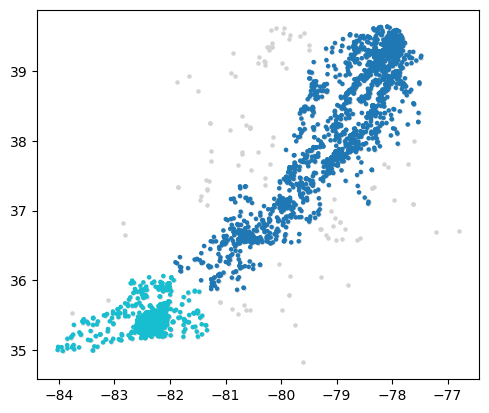

In [25]:
params = {
    'min_cluster_size': [500],
    'min_samples': [1],
    'cluster_selection_epsilon': [10], 
    'metric': ['haversine'],
    'core_dist_n_jobs': [-1],
}

for fig in generate_cluster_figures(find_hdbscan_clusters, gdf_sample, **params):
    print(fig)